In [1]:
import numpy as np, os, sys, joblib
from scipy.io import loadmat
import matplotlib.pyplot as plt
import scipy.fftpack
from scipy import signal

In [2]:
# Load data
def load_files(header_file):
    with open(header_file, 'r') as f:
        header = f.readlines()
    mat_file = header_file.replace('.hea', '.mat')
    x = loadmat(mat_file)
    recording = np.asarray(x['val'], dtype=np.float64)
    return recording, header

# Find unique classes
def get_classes(input_directory, filenames):
    classes = set()
    for filename in filenames:
        with open(filename, 'r') as f:
            for l in f:
                if l.startswith('#Dx'):
                    tmp = l.split(': ')[1].split(',')
                    for c in tmp:
                        classes.add(c.strip())
    return sorted(classes)

In [3]:
header_files = []
input_directory = 'prueba3/'
for f in os.listdir(input_directory):
    g = os.path.join(input_directory, f)
    if not f.lower().startswith('.') and f.lower().endswith('hea') and os.path.isfile(g):
        header_files.append(g)

classes = get_classes(input_directory, header_files)
num_classes = len(classes)
num_files = len(header_files)
recordings = list()
headers = list()

for i in range(num_files):
    recording, header = load_files(header_files[i])
    
    fs = int(header[0].split(' ')[2])
    
    if  fs != 500:
        upsampled_fs=500
        signal_len = np.shape(recording)[1]

        upsampled_recording = np.zeros((12,int(signal_len*upsampled_fs/fs)))
        for j in range(12):
            upsampled_recording[j,] = signal.resample(recording[j],int(signal_len*upsampled_fs/fs))
        
        recording = upsampled_recording     
      
    recordings.append(recording)
    headers.append(header)

In [4]:
labels = list()

for i in range(num_files):
    header = headers[i]
    for l in header:
        if l.startswith('#Dx:'):
            labels_act = np.zeros(num_classes)
            arrs = l.strip().split(' ')
            for arr in arrs[1].split(','):
                class_index = classes.index(arr.rstrip()) 
                labels_act[class_index] = 1
    labels.append(labels_act)

In [5]:
tags = list()

for i in range(num_files):
    header = headers[i]
    for l in header:
        if l.startswith('#Dx:'):
            labels_act = np.zeros(num_classes)
            arrs = l.strip().split(' ')
            tag = []
            for arr in arrs[1].split(','):
                tag.append(arr.rstrip())

    tags.append(tag)

### APPROACHES

- 1D-CNN as feature extractor 
- Waveform features, wavelets and other features as feature extractor + ??? feature selector 
- Future work --> LSTM + age/gender


### Preprocessing
- Filtering
    - Baseline wander: HPF (0.5 hz)
    - Power line interference: notch (50 hz)
- Segmentation --> pan-tompkins + padding/truncating
- Balancing --> smote


'HR00001 12 500 5000 04-Jun-2020 15:11:55\n'

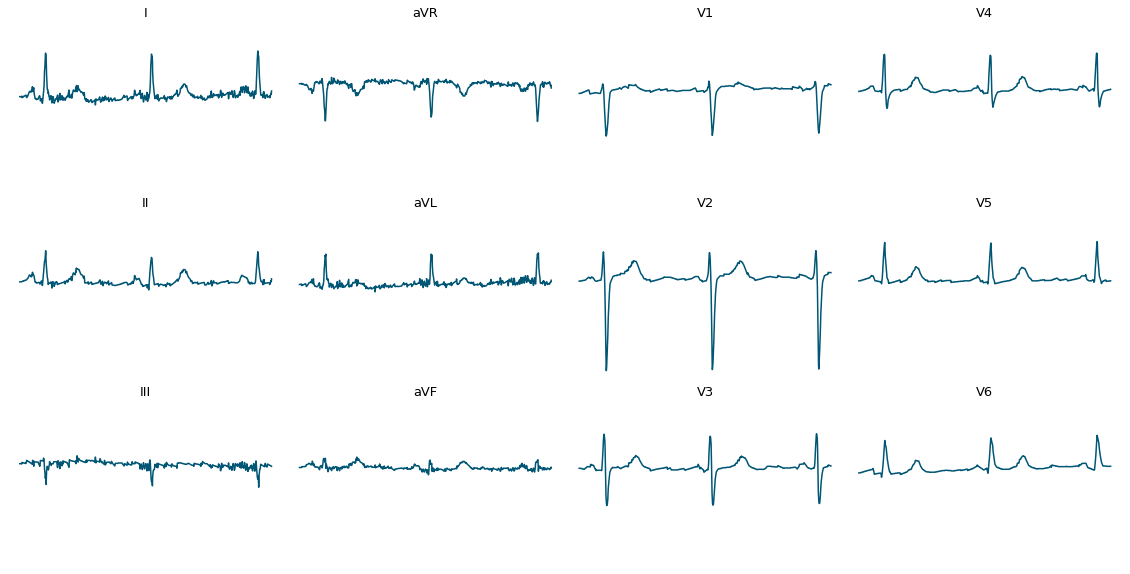

In [6]:
fig = plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace= 0.01, hspace= 0.15)

k=0
names = ['I', 'aVR', 'V1', 'V4', 'II', 'aVL', 'V2', 'V5', 'III', 'aVF', 'V3', 'V6']
for i in range(3):
    jj=0
    for j in range(4):
        
        ax=fig.add_subplot(3,4,k+1)
        plt.plot(recordings[0][i+3*jj][:1100],'#005674')
        plt.title(names[k], fontsize=13)

        #print(i+3*jj)
        k=k+1      
        jj = jj+1
        
        plt.ylim([-1500,1000])
        #ax.get_xaxis().set_visible(False)
        #ax.get_yaxis().set_visible(False)
        plt.axis('off')

headers[0][0]   #'HR00001 12 500 5000 04-Jun-2020 15:11:55\n'

## FILTERING

In [7]:
def butter_hpf(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    f_cutoff = cutoff / nyq
    b, a = signal.butter(order, f_cutoff, btype='high', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

def butter_notch(data, cutoff, fs, band=0.5, order=5):
    nyq = 0.5 * fs
    low  = cutoff - band/2.0
    high = cutoff + band/2.0
    low  = low/nyq
    high = high/nyq    
    b, a = signal.butter(order, [low,high], btype='bandstop', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

ecgs_mean = list()
ecgs_hpf = list()
ecgs_notch = list()
ecgs_sgol = list()

for recording in recordings:

    # Substract the mean
    ecg_mean = recording - np.reshape(np.mean(recording, axis = 1),(12,1))

    # Remove baseline wander (HPF, f_cutoff = 0.5)
    ecg_hpf = butter_hpf(ecg_mean, 0.5, 500, order=5)
    
    # Remove 50Hz power component (notch filter,f_cutoff = 50)
    ecg_notch = butter_notch(ecg_hpf, 50, 500, order=5)

    # Smooth the signal (leastsquares polynomial fitting for sample smoothing, has an important peak preserving property which is very useful in ECG signal analysis)
    ecg_sgol = signal.savgol_filter(ecg_notch, 25,4)
    
    ecgs_mean.append(ecg_mean)
    ecgs_hpf.append(ecg_hpf)
    ecgs_notch.append(ecg_notch)
    ecgs_sgol.append(ecg_sgol)


'HR00026 12 500 5000 04-Jun-2020 15:11:55\n'

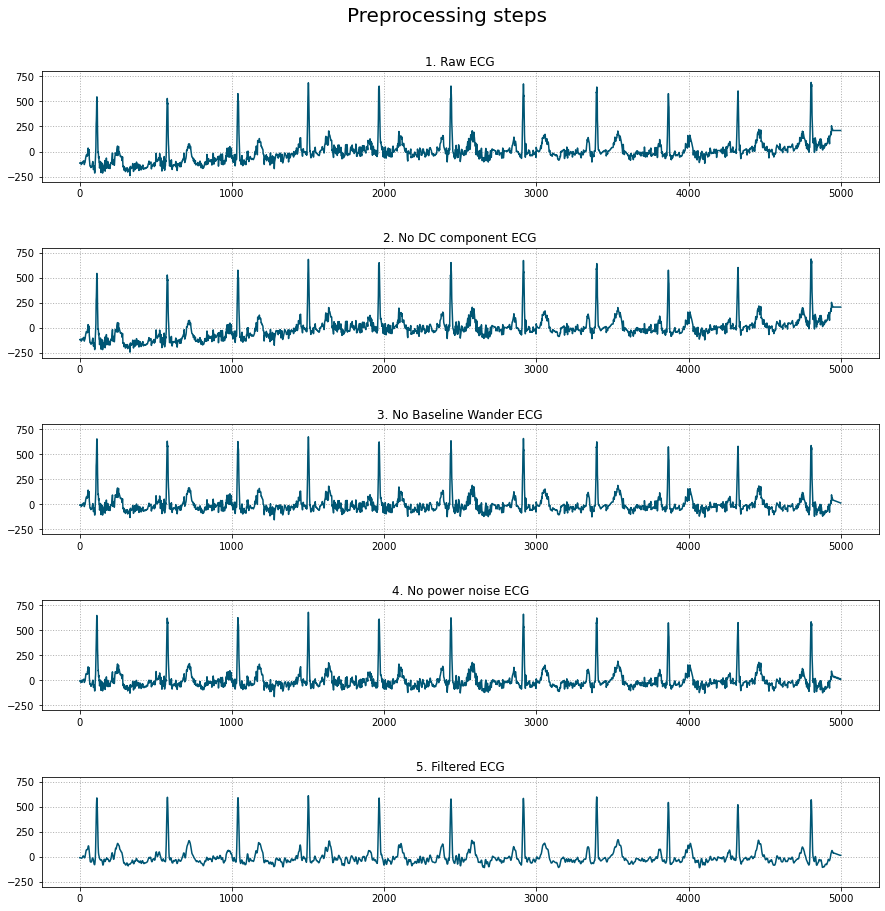

In [8]:
fig = plt.figure(figsize=(15, 15))
fig.suptitle('Preprocessing steps', fontsize=20, y=0.94)
plt.subplots_adjust(wspace= 0.15, hspace= 0.60)

i = 0

sub1 = fig.add_subplot(5,1,1) 
plt.plot(recordings[i][0],'#005674')
plt.ylim([-300,800])
plt.title('1. Raw ECG')
sub1.grid(linestyle='dotted', linewidth=1)

sub2 = fig.add_subplot(5,1,2) 
plt.plot(ecgs_mean[i][0],'#005674')
plt.ylim([-300,800])
plt.title('2. No DC component ECG')
sub2.grid(linestyle='dotted', linewidth=1)

sub3 = fig.add_subplot(5,1,3) 
plt.plot(ecgs_hpf[i][0],'#005674')
plt.ylim([-300,800])
plt.title('3. No Baseline Wander ECG')
sub3.grid(linestyle='dotted', linewidth=1)

sub4 = fig.add_subplot(5,1,4) 
plt.plot(ecgs_notch[i][0],'#005674')
plt.ylim([-300,800])
plt.title('4. No power noise ECG')
sub4.grid(linestyle='dotted', linewidth=1)

sub5 = fig.add_subplot(5,1,5) 
plt.plot(ecgs_sgol[i][0],'#005674')
plt.ylim([-300,800])
plt.title('5. Filtered ECG')
sub5.grid(linestyle='dotted', linewidth=1)

del ecgs_mean, ecgs_hpf, ecgs_notch

headers[25][0]   #'HR00001 12 500 5000 04-Jun-2020 15:11:55\n'

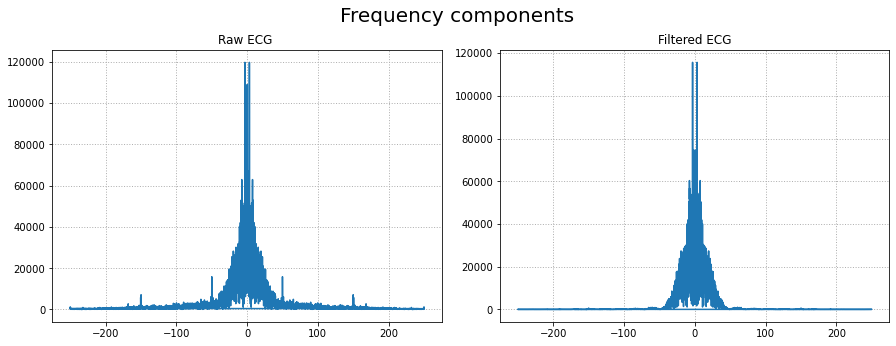

In [9]:
# Number of samplepoints
N = 5000
# sample spacing
T = 1.0 / 500.0

fig = plt.figure(figsize=(15, 5))
fig.suptitle('Frequency components', fontsize=20, y=1)
plt.subplots_adjust(wspace= 0.15, hspace= 0.60)

sub1 = fig.add_subplot(1,2,1) 
Y    = np.fft.fft(recordings[0][0])
freq = np.fft.fftfreq(len(recordings[0][0]), T)
plt.plot( freq, np.abs(Y) )
plt.title('Raw ECG ')
sub1.grid(linestyle='dotted', linewidth=1)

sub2 = fig.add_subplot(1,2,2) 
Y    = np.fft.fft(ecgs_sgol[0][0])
freq = np.fft.fftfreq(len(ecgs_sgol[0][0]), T)
plt.plot( freq, np.abs(Y) )
plt.title('Filtered ECG')
sub2.grid(linestyle='dotted', linewidth=1)

## SEGMENTATION

In [10]:
def butter_bpf(data, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

def findpeaks(data, spacing=1, limit=None):
        """
        Janko Slavic peak detection algorithm and implementation.
        https://github.com/jankoslavic/py-tools/tree/master/findpeaks
        Finds peaks in `data` which are of `spacing` width and >=`limit`.
        :param ndarray data: data
        :param float spacing: minimum spacing to the next peak (should be 1 or more)
        :param float limit: peaks should have value greater or equal
        :return array: detected peaks indexes array
        """
        len = data.size
        x = np.zeros(len + 2 * spacing)
        x[:spacing] = data[0] - 1.e-6
        x[-spacing:] = data[-1] - 1.e-6
        x[spacing:spacing + len] = data
        peak_candidate = np.zeros(len)
        peak_candidate[:] = True
        for s in range(spacing):
            start = spacing - s - 1
            h_b = x[start: start + len]  # before
            start = spacing
            h_c = x[start: start + len]  # central
            start = spacing + s + 1
            h_a = x[start: start + len]  # after
            peak_candidate = np.logical_and(peak_candidate, np.logical_and(h_c > h_b, h_c > h_a))

        ind = np.argwhere(peak_candidate)
        ind = ind.reshape(ind.size)
        if limit is not None:
            ind = ind[data[ind] > limit]
        return ind


filter_lowcut = 1 #Hz
filter_highcut = 13 #Hz
signal_frequency = 500 #Hz
filter_order = 5
integration_window = 100

ecg_segments = list()
ecg_segments_band = list()
ecg_segments_der = list()
ecg_segments_sq = list()
ecg_segments_ma = list()
ecg_segments_pv = list()
ecg_segments_pi = list()
ecg_segments_seg = list()

for i in range(num_files):

    # Measurements filtering - 5-15 Hz band pass filter
    ecgs_band = butter_bpf(ecgs_sgol[i][0], lowcut=filter_lowcut, highcut=filter_highcut, fs=signal_frequency, order=filter_order)

    # Derivative - provides QRS slope information
    ecgs_der = np.ediff1d(ecgs_band)

    # Squaring - intensifies values received in derivative
    ecgs_sq = ecgs_der ** 2

    # Moving-window integration
    ecgs_ma = np.convolve(ecgs_sq, np.ones(integration_window)/integration_window, mode='same')
    
    # Fiducial mark - peak detection on integrated measurements
    detected_peaks_indices = findpeaks(data=ecgs_ma,limit=0.35,spacing=200)
    detected_peaks_values = ecgs_sgol[i][0][detected_peaks_indices]
    
    # Segmentation
    # https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8691755&casa_token=LL2mSud47XoAAAAA:O3-63j0il9bfa8yxPwubKyYLVmjerzDD6K-QWnrl6O5RgInOKYASY-d3RLnBqO8LV8I12RVN
    aux_indx = np.concatenate(([0],detected_peaks_indices))
    ecgs_seg = [np.int((aux_indx[i+1]-aux_indx[i])*0.65 + aux_indx[i]) for i in range(np.shape(aux_indx)[0]-1)]
    ecgs_seg = ecgs_seg[1:]
    
    ecg_segments_band.append(ecgs_band)
    ecg_segments_der.append(ecgs_der)
    ecg_segments_sq.append(ecgs_sq)
    ecg_segments_ma.append(ecgs_ma)
    ecg_segments_pv.append(detected_peaks_values)
    ecg_segments_pi.append(detected_peaks_indices)
    ecg_segments_seg.append(ecgs_seg)


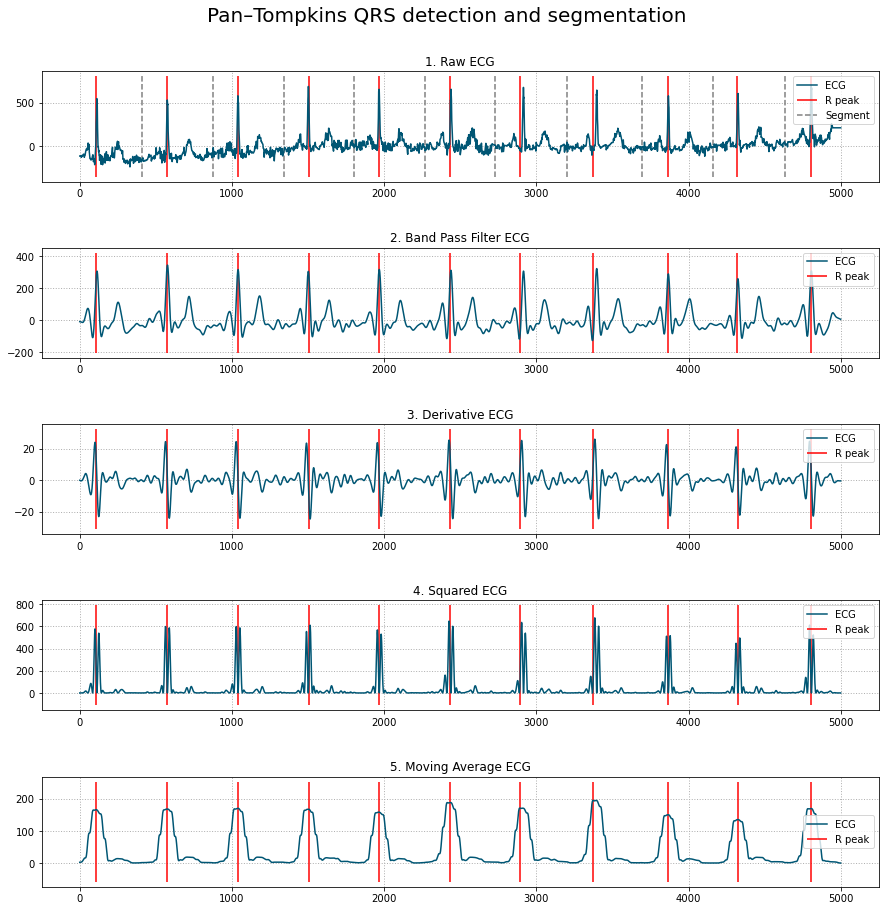

In [11]:
fig = plt.figure(figsize=(15, 15))
fig.suptitle('Pan–Tompkins QRS detection and segmentation', fontsize=20, y=0.94)
plt.subplots_adjust(wspace= 0.15, hspace= 0.60)

sub1 = fig.add_subplot(5,1,1) 
var = recordings[0][0]
plt.plot(var,'#005674', label ='ECG')
plt.vlines(ecg_segments_pi[0], ymin=np.min(var)-np.std(var), ymax=np.max(var)+np.std(var), color='r', label = 'R peak')
plt.vlines(ecg_segments_seg[0], ymin=np.min(var)-np.std(var), ymax=np.max(var)+np.std(var), color='grey', linestyles='dashed', label = 'Segment')
plt.title('1. Raw ECG');plt.legend(loc="upper right")
sub1.grid(linestyle='dotted', linewidth=1)

sub2 = fig.add_subplot(5,1,2)
var = ecg_segments_band[0]
plt.plot(var,'#005674', label ='ECG')
plt.vlines(ecg_segments_pi[0], ymin=np.min(var)-np.std(var), ymax=np.max(var)+np.std(var), color='r', label = 'R peak')
#plt.vlines(aa, ymin=np.min(var)-np.std(var), ymax=np.max(var)+np.std(var), color='k')
plt.title('2. Band Pass Filter ECG');plt.legend()
sub2.grid(linestyle='dotted', linewidth=1)

sub3 = fig.add_subplot(5,1,3) 
var = ecg_segments_der[0]
plt.plot(var,'#005674', label ='ECG')
plt.vlines(ecg_segments_pi[0], ymin=np.min(var)-np.std(var), ymax=np.max(var)+np.std(var), color='r', label = 'R peak')
plt.title('3. Derivative ECG');plt.legend()
sub3.grid(linestyle='dotted', linewidth=1)

sub4 = fig.add_subplot(5,1,4) 
var = ecg_segments_sq[0]
plt.plot(var,'#005674', label ='ECG')
plt.vlines(ecg_segments_pi[0], ymin=np.min(var)-np.std(var), ymax=np.max(var)+np.std(var), color='r', label = 'R peak')
plt.title('4. Squared ECG');plt.legend()
sub4.grid(linestyle='dotted', linewidth=1)

sub5 = fig.add_subplot(5,1,5) 
var = ecg_segments_ma[0]
plt.plot(var,'#005674', label ='ECG')
plt.vlines(ecg_segments_pi[0], ymin=np.min(var)-np.std(var), ymax=np.max(var)+np.std(var), color='r', label = 'R peak')
plt.title('5. Moving Average ECG');plt.legend()
sub5.grid(linestyle='dotted', linewidth=1)

del var, ecg_segments_band, ecg_segments_der, ecg_segments_sq, ecg_segments_ma, ecg_segments_pv, ecg_segments_pi

Segmentar y pad/chop para tener el mismo size

In [12]:
def padding(array, xx, yy):
    """
    :param xx: desired height
    :param yy: desired width
    """

    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h
    b = (yy - w) // 2
    bb = yy - b - w

    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

def chop(array, xx, yy):

    h = array.shape[0]
    w = array.shape[1]
    
    a = (h - xx) // 2
    aa = a + xx
    b = (w - yy) // 2
    bb = b + yy

    return array[a:aa,b:bb]
    

In [76]:
from scipy import stats
import statistics
import math
import pywt

from collections import Counter 
import scipy
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [median, mean, std, var, rms]
 
def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]
 
def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics


segmented_signal = list()
segment_label = list()
seg_leads_adj = []

for i in range(num_files):
    
    signal = ecgs_sgol[i]
    idx_segments = ecg_segments_seg[i]
    
    segmented_leads = np.array_split(signal, idx_segments, 1)
    segmented_leads_adj = list()
    segment_lab = list()

    for j in range(len(idx_segments)+1): # cada segmento
        
        segment_length = segmented_leads[j].shape[1]
        
        if segment_length < 500:
            seg_leads_adj = padding(segmented_leads[j],12, 500)
        else:
            seg_leads_adj = chop(segmented_leads[j],12,500)
            
            
        # Extract features
        mean_sig=np.mean(seg_leads_adj,axis=1)
        std_sig=np.std(seg_leads_adj,axis=1)
        median_sig=np.nanpercentile(seg_leads_adj,50,axis=1)
        max_sig=np.max(seg_leads_adj,axis=1)
        min_sig=np.min(seg_leads_adj,axis=1)

        rms=np.sqrt(np.mean(seg_leads_adj**2,axis=1))
        zero_cross = []
        spectral_energy = []
        for k in range(12):
            aa=len(np.where(np.diff(np.sign(seg_leads_adj[k])))[0])/len(seg_leads_adj[k])
            zero_cross.append(aa)

            bb=np.sum(np.absolute(np.fft.fft(seg_leads_adj[k])**2))
            spectral_energy.append(bb)

        zero_cross = np.array(zero_cross)     
        spectral_energy=np.array(spectral_energy) 

        coeffs, freqs = pywt.cwt(seg_leads_adj[0], scales= np.arange(1, 65), wavelet = 'morl')
        list_coeff = pywt.wavedec(seg_leads_adj[0], 'db4')
        w_features = []
        for coeff in list_coeff:
            w_features += get_features(coeff)  
            
        
        feats = np.concatenate([mean_sig,std_sig,median_sig,max_sig,min_sig,rms,zero_cross,spectral_energy,w_features])    
        segmented_leads_adj.append(feats)
        segment_lab.append(labels[i])
    
    segmented_signal.append(segmented_leads_adj)   #segmented_signal[signal][segment] 
    segment_label.append(segment_lab)              #segment_label[signal][segment]   

In [77]:
#convert into array
X = np.array([np.array(x) for xi in segmented_signal for x in xi])
y = np.array([np.array(x) for xi in segment_label for x in xi])

In [78]:
print(X.shape)
print(y.shape)

(133443, 152)
(133443, 68)


In [79]:
# Train/test split

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.3)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    stratify=y_train, 
                                                    test_size=0.35)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

del X, y

(60716, 152)
(60716, 68)
(40033, 152)
(40033, 68)
(32694, 152)
(32694, 68)


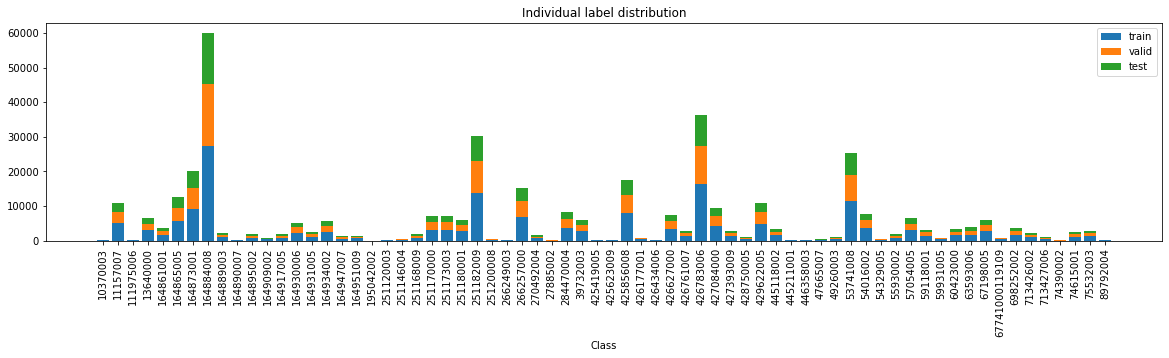

In [80]:
plt.figure(figsize=(20, 4))
kk=np.sum(y_train, axis = 0)
plt.bar(classes,kk,label='train')
kk1=np.sum(y_valid, axis = 0)
plt.bar(classes,kk1,label='valid',bottom=kk)
kk2=np.sum(y_test, axis = 0)
plt.bar(classes,kk2,label='test',bottom=kk1+kk)
plt.legend()
plt.xticks(rotation = 90);
plt.title('Individual label distribution')
plt.xlabel('Class');

In [81]:
import numpy as np
import pandas as pd
import random
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

def get_tail_label(df: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = df.sum(axis=0)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    tail_labels = get_tail_label(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target



X1 = pd.DataFrame(X_train)
y1 = pd.DataFrame(y_train)
X_sub, y_sub = get_minority_samples(X1, y1)   #Getting minority instance of that dataframe
X_res,y_res = MLSMOTE(X_sub, y_sub, 15000,10)     #Applying MLSMOTE to augment the dataframe

X3 = np.concatenate([X1, X_res])
y2 = np.concatenate([y1, y_res])

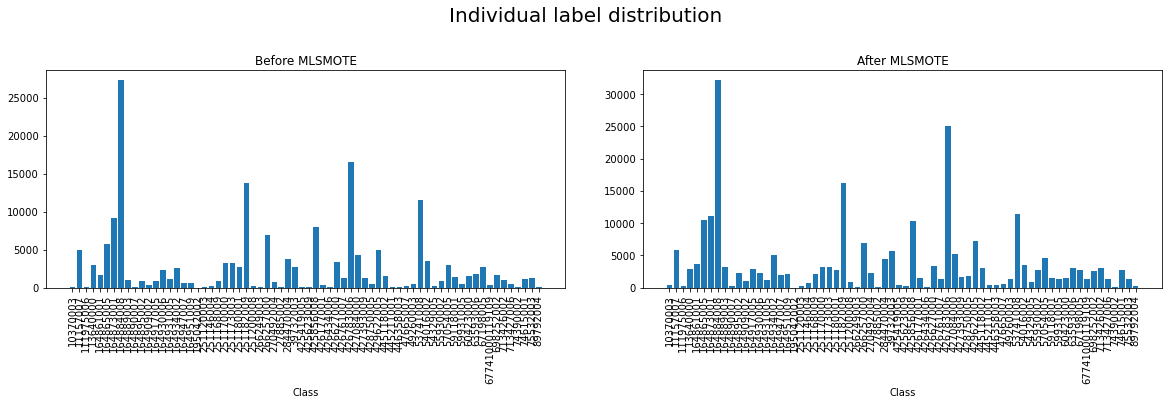

In [82]:
fig = plt.figure(figsize=(20, 4))
fig.suptitle('Individual label distribution', fontsize=20, y=1.1)
plt.subplots_adjust(wspace= 0.15, hspace= 0.60)

sub1 = fig.add_subplot(1,2,1) 
kk=np.sum(y_train, axis = 0)
plt.bar(classes,kk)
plt.xticks(rotation = 90);
plt.title('Before MLSMOTE')
plt.xlabel('Class')

sub2 = fig.add_subplot(1,2,2) 
kk=np.sum(y2, axis = 0)
plt.bar(classes,kk)
plt.xticks(rotation = 90);
plt.title('After MLSMOTE')
plt.xlabel('Class');

In [83]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, BatchNormalization

n_features, n_outputs =  X3.shape[1], y2.shape[1]

keras.backend.clear_session() # clear previous model

model = Sequential()
model.add(Dense(8, input_dim=n_features, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [84]:
import datetime 

train_start = datetime.datetime.now()
history = model.fit(
    X3,
    y2,
    epochs=20,
    batch_size=32,
    shuffle=True,
    #verbose=0,
    validation_data=(X_valid, y_valid)
)
train_end = datetime.datetime.now()

Epoch 1/20
2367/2367 [==============================] - 8s 3ms/step - loss: 0.2079 - accuracy: 0.2280 - val_loss: 0.1209 - val_accuracy: 0.2834
Epoch 2/20
2367/2367 [==============================] - 5s 2ms/step - loss: 0.1381 - accuracy: 0.2623 - val_loss: 0.1355 - val_accuracy: 0.2826
Epoch 3/20
2367/2367 [==============================] - 5s 2ms/step - loss: 0.1310 - accuracy: 0.2851 - val_loss: 0.1362 - val_accuracy: 0.2824
Epoch 4/20
2367/2367 [==============================] - 5s 2ms/step - loss: 0.1257 - accuracy: 0.2983 - val_loss: 0.1137 - val_accuracy: 0.3021
Epoch 5/20
2367/2367 [==============================] - 4s 2ms/step - loss: 0.1236 - accuracy: 0.2956 - val_loss: 0.1289 - val_accuracy: 0.2850
Epoch 6/20
2367/2367 [==============================] - 5s 2ms/step - loss: 0.1214 - accuracy: 0.3004 - val_loss: 0.1114 - val_accuracy: 0.3283
Epoch 7/20
2367/2367 [==============================] - 5s 2ms/step - loss: 0.1199 - accuracy: 0.3029 - val_loss: 0.1275 - val_accuracy:

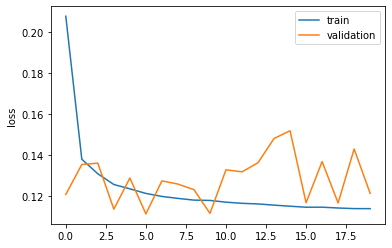

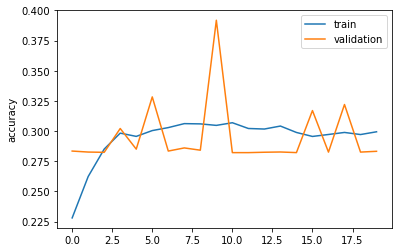

In [85]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.legend(['train','validation'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.legend(['train','validation'])
plt.show()

In [86]:
y_test_pred = model.predict(X_test)
y_preds = np.round(y_test_pred)

In [87]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score,roc_auc_score
print('f1-score', f1_score(y_test,y_preds, average='weighted'))
print('accuracy', accuracy_score(y_test,y_preds))
print('recall', recall_score(y_test,y_preds,average='weighted'))
print('precision', precision_score(y_test,y_preds,average='weighted'))
print('auc', roc_auc_score(y_test,y_preds,average='weighted'))

f1-score 0.1556759935547136
accuracy 0.02801737321832752
recall 0.16760336155719813


C:\Users\lgarc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision 0.3518906696583092
auc 0.5450221466080635


In [88]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_test, np.round(y_test_pred))

array([[[32626,     2],
        [   66,     0]],

       [[30021,    17],
        [ 2266,   390]],

       [[32668,     0],
        [   26,     0]],

       [[31094,    14],
        [ 1580,     6]],

       [[31780,    43],
        [  868,     3]],

       [[29625,     2],
        [ 3067,     0]],

       [[27695,    77],
        [ 4824,    98]],

       [[ 9084,  8935],
        [ 1150, 13525]],

       [[32127,     9],
        [  554,     4]],

       [[32651,     4],
        [   39,     0]],

       [[32228,     0],
        [  466,     0]],

       [[32494,    24],
        [  151,    25]],

       [[32238,     1],
        [  455,     0]],

       [[31456,     0],
        [ 1238,     0]],

       [[32091,    13],
        [  590,     0]],

       [[31298,     1],
        [ 1395,     0]],

       [[32375,     2],
        [  317,     0]],

       [[32367,     0],
        [  327,     0]],

       [[32692,     0],
        [    2,     0]],

       [[32659,     3],
        [   32,     0]],



------------------